# SQL-Agent

- Author: [Jinu Cho](https://github.com/jinucho)
- Design: 
- Peer Review: 
- Proofread:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/14-Chains/02-SQL.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/14-Chains/02-SQL.ipynb)

## Overview

In this tutorial, we will build an agent step-by-step that can answer questions

![sql-agent-work-flow](./assets/09-sql-agent-work-flow.png)

**Key Topics** :
1. **Database** : Set up an SQLite database and load the Chinook sample database.
2. **Utility Functions** : Define utility functions for implementing the agent.
3. **Tool Definitions** : Define tools for interacting with the database.
4. **Workflow Definition** : Define the workflow (graph) for the agent.
5. **Graph Visualization** : Visualize the defined workflow graph.
6. **Agent Execution** : Execute the agent and review the results.
7. **Evaluation** : Evaluate the agent and compare its performance.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Agent for Interacting with SQL Databases](#agent-for-interacting-with-sql-databases)
- [Set Up the Database](#set-up-the-database)
- [Utility Functions](#utility-functions)
- [SQL Query Execution Tools](#sql-query-execution-tools)
- [SQLDatabaseToolkit Tools](#sqldatabasetoolkit-tools)
- [SQL Query Checker](#sql-query-checker)
- [Graph Definition](#graph-definition)
- [Evaluating an SQL Agent Using LangSmith Evaluator](#evaluating-an-sql-agent-using-langsmith-evaluator)

### References
- [SQLite Sample Database](https://www.sqlitetutorial.net/sqlite-sample-database/)
- [Langchain core](https://python.langchain.com/api_reference/core/messages.html#module-langchain_core)
- [SQLDatabaseToolkit](https://python.langchain.com/api_reference/community/agent_toolkits/langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit.html#langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit)
- [LangGraph](https://langchain-ai.github.io/langgraph)
- [LangSmith.Client](https://docs.smith.langchain.com/reference/python/client/langsmith.client.Client)
- [LangSmith.evaluation](https://docs.smith.langchain.com/reference/python/evaluation)
---

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.

Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langgraph",
        "langchain_openai",
        "langchain_community",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


You can alternatively set ```OPENAI_API_KEY``` in ```.env``` file and load it. 

[Note] This is not necessary if you've already set ```OPENAI_API_KEY``` in previous steps.

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "09-SQL-Agent",
    }
)

Environment variables have been set successfully.


In [4]:
# Load environment variables
# Reload any variables that need to be overwritten from the previous cell

from dotenv import load_dotenv

load_dotenv(override=True)

True

In [5]:
# Set LLM Model
MODEL_NAME = "gpt-4o-mini"

## Agent for Interacting with SQL Databases


The workflow of an agent that executes SQL queries is as follows:

1. **Understanding the Database Schema** : Retrieve a list of available tables.
2. **Selecting Relevant Tables** : Identify tables related to the question.
3. **Fetching DDL** : Obtain the schema definitions (DDL) of the selected tables.
4. **Generating Queries** : Construct SQL queries based on the question and DDL information.
5. **Query Validation** : Use an LLM to review for common errors and refine the query.
6. **Query Execution and Error Handling** : Execute the query on the database engine and handle errors to ensure successful execution.
7. **Generating Responses** : Provide the final answer based on the query results.

## Set Up the Database

In this tutorial, we will create an SQLite database. SQLite is a lightweight database that is easy to set up and use.

For this tutorial, we will load the Chinook sample database, which represents a digital media store.

You can find more information about the Chinook database [here](https://www.sqlitetutorial.net/sqlite-sample-database/).

First, download the Chinook database to use for the exercises in this tutorial.

In [6]:
import requests
import os

if os.path.exists("data/Chinook.db"):
    print("File already exists")
else:
    print("Downloading file...")
    url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
    response = requests.get(url)
    if response.status_code == 200:
        os.makedirs("data", exist_ok=True)
        with open("data/Chinook.db", "wb") as file:
            file.write(response.content)
        print("File downloaded and saved as Chinook.db")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

File already exists


### Using the Chinook Database

Next, we will create an ```SQLDatabase``` tool using the downloaded Chinook database and execute a sample query, **"SELECT * FROM Artist LIMIT 5;"** .

In [7]:
from langchain_community.utilities import SQLDatabase

# Create an SQLDatabase instance from the SQLite database file
db = SQLDatabase.from_uri("sqlite:///data/Chinook.db")

# Print the database dialect (sqlite)
print(f"db dialect : {db.dialect}")

# Print the list of usable table names in the database
print(f"table names in db : {db.get_usable_table_names()}")

# Execute an SQL query
db.run("SELECT * FROM Artist LIMIT 5;")

db dialect : sqlite
table names in db : ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]"

## Utility Functions

Let's define several utility functions to assist in implementing the agent.

In particular, wrap ```ToolNode``` to include error handling and the capability to relay errors back to the agent.

In [8]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


# Error handling function
def handle_tool_error(state) -> dict:
    # Check error information
    error = state.get("error")
    # Check tool information
    tool_calls = state["messages"][-1].tool_calls
    # Wrap with ToolMessage and return
    return {
        "messages": [
            ToolMessage(
                content=f"Here is the error: {repr(error)}\n\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


# Create a ToolNode to handle errors and surface them to the agent
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    # Add fallback behavior for error handling to the ToolNode
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

## SQL Query Execution Tools

To enable the agent to interact with the database, we define several tools.

### Defined Tools:
- ```list_tables_tool``` : Retrieves a list of available tables in the database.
- ```get_schema_tool```  : Fetches the DDL (Data Definition Language) of a table.
- ```db_query_tool```  : Executes queries and retrieves results or returns error messages if the query fails.

### Note:
DDL (Data Definition Language) refers to SQL commands used to define or modify the structure and schema of a database. It includes commands to create, alter, and delete database objects like tables, indexes, and views.

### Key DDL Commands:
- **CREATE** : Creates database objects.
  - Example: CREATE TABLE users (id INT, name VARCHAR(100));
- **ALTER** : Modifies existing database objects.
  - Example: ALTER TABLE users ADD COLUMN email VARCHAR(100);
- **DROP** : Deletes database objects.
  - Example: DROP TABLE users;
---

## SQLDatabaseToolkit Tools

The following tools are provided to interact with the SQL database:

1. ```QuerySQLDatabaseTool```
   - **Function** : Executes SQL queries and returns results.
   - **Input** : Valid SQL query.
   - **Output** : Database results or error messages.
   - **Error Handling** :
     - Rewrites and retries the query if errors occur.
     - Resolves "unknown column" errors by checking table fields using ```sql_db_schema``` .

2. ```InfoSQLDatabaseTool```
   - **Function** : Retrieves table schemas and sample data.
   - **Input** : Comma-separated list of table names.
   - **Usage Example** : table1, table2, table3
   - **Note** : Check table existence using ```sql_db_list_tables``` before using this tool.

3. ```ListSQLDatabaseTool```
   - **Function** : Retrieves a list of tables in the database.

4. ```QuerySQLCheckerTool```
   - **Function** : Validates SQL queries before execution.
   - **Validation Checks** :
     - Use of **NULL** values and **NOT IN** .
     - Suitability of **UNION** vs **UNION ALL** .
     - Correct range settings for **BETWEEN** .
     - Data type consistency.
     - Proper quoting of identifiers.
     - Correct number of function arguments.
     - Proper type casting.
     - Accuracy of join columns.
   - **Features** : Uses a GPT-4o model for validation.


In [9]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

# Create SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model=MODEL_NAME))

# Get the list of available tools from the SQLDatabaseToolkit
tools = toolkit.get_tools()
for tool in tools:
    print(f"class_name : {tool.__class__}")
    print(f"description : {tool.description}")
    print()

class_name : <class 'langchain_community.tools.sql_database.tool.QuerySQLDatabaseTool'>
description : Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

class_name : <class 'langchain_community.tools.sql_database.tool.InfoSQLDatabaseTool'>
description : Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

class_name : <class 'langchain_community.tools.sql_database.tool.ListSQLDatabaseTool'>
description : Input is an empty string, output is a comma-separated list of tables in the database.

class_name : <class 'lang

Below is an example of executing ```list_tables_tool``` and ```get_schema_tool``` .

In [10]:
# Select the tool for listing available tables in the database
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

# Select the tool for retrieving the DDL of a specific table
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# Print the list of all tables in the database
print(f'list_tables :\n`{list_tables_tool.invoke("")}')

print("-" * 100)

# Print the DDL information for the Artist table
print(f'schema :\n{get_schema_tool.invoke("Artist")}')

list_tables :
`Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
----------------------------------------------------------------------------------------------------
schema :

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


Next, define ```db_query_tool``` .

In ```db_query_tool``` case, it executes queries against the database and returns the results.

If an error occurs, it returns an error message.

In [11]:
from langchain_core.tools import tool


# Query execution tool
@tool
def db_query_tool(query: str) -> str:
    """
    Run SQL queries against a database and return results
    Returns an error message if the query is incorrect
    If an error is returned, rewrite the query, check, and retry
    """
    # Execute query
    result = db.run_no_throw(query)

    # Error: Return error message if no result
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    # Success: Return the query execution result
    return result

When executed successfully.

In [12]:
# Select the top 10 rows from the Artist table and print the execution result
print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


When an error occurs.

This will produce an error due to the incorrect SQL syntax ("LIMITS" instead of "LIMIT")

In [13]:
# Attempt to select the top 10 rows from the Artist table and print the result
print(db_query_tool.invoke("SELECT * FROM Artist LIMITS 10;"))

Error: (sqlite3.OperationalError) near "10": syntax error
[SQL: SELECT * FROM Artist LIMITS 10;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


## SQL Query Checker

Next, we will use an LLM to check for common mistakes in SQL queries.

Strictly speaking, this is not a tool, but it will be added as a node in the workflow later.

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Define a system message to check SQL queries for common mistakes
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# Create the prompt
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)

# Create the Query Checker chain
query_check = query_check_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).bind_tools([db_query_tool], tool_choice="db_query_tool")

### Verify the Fix for Incorrect Query

An incorrect query was executed to check if the issue is properly handled and fixed.

**Remark** :  
The query used ```LIMITS``` instead of ```LIMIT``` .


In [15]:
# Execute the query check node using the user's message
response = query_check.invoke(
    {"messages": [("user", "SELECT * FROM Artist LIMITS 10;")]}
)
print(response.tool_calls[0])

{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_oLpZXFYZmlUJ8sMbqthr4B1U', 'type': 'tool_call'}


The input query contained an error, but the generated query was successfully corrected.

**Correction**: LIMITS → LIMIT

## Graph Definition

Define the workflow for the agent.

The agent first forcefully invokes the ```list_tables_tool``` to retrieve the available tables from the database. After this, it follows the steps mentioned earlier in the tutorial.

In [16]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver


# Define the agent's state
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Create a new graph
workflow = StateGraph(State)


# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "initial_tool_call_abc123",
                    }
                ],
            )
        ]
    }


# Define a function to check query accuracy with a model
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to check that your query is correct before you run it
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


# Add a node for the first tool call
workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a model node to select relevant tables based on the question and available tables
model_get_schema = ChatOpenAI(model=MODEL_NAME, temperature=0).bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)

# Add a model node to generate a query based on the question and schema
QUERY_GEN_INSTRUCTION = """You are a SQL expert with a strong attention to detail.

You can define SQL queries, analyze queries results and interpretate query results to response an answer.

Read the messages bellow and identify the user question, table schemas, query statement and query result, or error if they exist.

1. If there's not any query result that make sense to answer the question, create a syntactically correct SQLite query to answer the user question. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

2. If you create a query, response ONLY the query statement. For example, "SELECT id, name FROM pets;"

3. If a query was already executed, but there was an error. Response with the same error message you found. For example: "Error: Pets table doesn't exist"

4. If a query was already executed successfully interpretate the response and answer the question following this pattern: Answer: <<question answer>>. 
    For example: "Answer: There three cats registered as adopted"
"""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", QUERY_GEN_INSTRUCTION), ("placeholder", "{messages}")]
)


query_gen = query_gen_prompt | ChatOpenAI(model=MODEL_NAME, temperature=0).bind_tools(
    [model_check_query]
)


# Define conditional edges
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    message = state["messages"][-1].content

    # 1) Terminate if the message starts with "Answer:"
    if message.startswith("Answer:"):
        return END

    # 2) Follow existing logic for other cases
    elif message.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Define the query generation node
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # If the LLM makes incorrect tool calls, return error messages
    tool_messages = []
    message.pretty_print()
    if message.tool_calls:
        for tc in message.tool_calls:
            tool_messages.append(
                ToolMessage(
                    content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                    tool_call_id=tc["id"],
                )
            )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


# Add the query generation node
workflow.add_node("query_gen", query_gen_node)

# Add a node to check the query with the model before execution
workflow.add_node("correct_query", model_check_query)

# Add a node to execute the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# Specify edges between nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into an executable app
app = workflow.compile(checkpointer=MemorySaver())

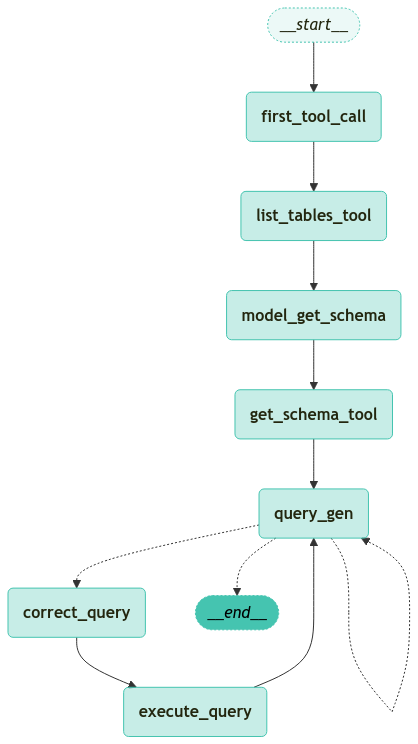

In [17]:
# check the graph workflow
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(app)

### Excution the Agent

Execute the agent to interact with an SQL database through the entire process.

The agent retrieves information from the database based on user queries, generates and executes SQL queries, and returns the results.

In [18]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import random_uuid, invoke_graph, stream_graph
from langchain_core.messages import HumanMessage
from langgraph.errors import GraphRecursionError


def run_graph(
    message: str, recursive_limit: int = 30, node_names=[], stream: bool = False
):
    # Configure settings (maximum recursion depth, thread ID)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # Input the user's query
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    try:
        if stream:
            # Execute the graph with streaming
            stream_graph(app, inputs, config, node_names=node_names)
        else:
            # Execute the graph without streaming
            invoke_graph(app, inputs, config, node_names=node_names)
        # Retrieve and return the output state values
        output = app.get_state(config).values
        return output
    except GraphRecursionError as recursion_error:
        print(f"GraphRecursionError: {recursion_error}")
        # Return output state values even in case of a recursion error
        output = app.get_state(config).values
        return output

In [19]:
output = run_graph(
    "Let me know all personal information about employee Andrew Adam.",
    stream=False,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (initial_tool_call_abc123)
 Call ID: initial_tool_call_abc123
  Args:

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_7LsScKaQEKiBo1xZ3QtEXEmX)
 Call ID: call_7LsScKaQEKiBo1xZ3QtEXEmX
  Args:
    table_names: Employee

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message ===========================

In [20]:
output = run_graph(
    "Which country's customers spent the most in 2009, and how much did they spend?",
    stream=False,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (initial_tool_call_abc123)
 Call ID: initial_tool_call_abc123
  Args:

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_xLI2mKHH0Bx5RfFI2ASXQqJ5)
 Call ID: call_xLI2mKHH0Bx5RfFI2ASXQqJ5
  Args:
    table_names: Customer, Invoice

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message ==================

## Evaluating an SQL Agent Using LangSmith Evaluator

Now, let's evaluate the SQL Agent's responses to queries. To do this, we'll first create a dataset specifically designed for evaluation purposes.

Next, we define an evaluator and proceed with the evaluation process.

For this, we use **LLM-as-judge** as the evaluator. The prompt employed will be the default one provided by the evaluation prompt hub.

However, for more precise evaluations, it is recommended to fine-tune the prompt to suit your specific needs.

In [21]:
from langsmith import Client

# Initialize the client
client = Client()

# Create and upload the dataset
examples = [
    (
        "Which country's customers spent the most? And how much did they spend?",
        "The country whose customers spent the most is the USA, with a total spending of 523.06.",
    ),
    (
        "What was the most purchased track of 2013?",
        "The most purchased track of 2013 was Hot Girl.",
    ),
    (
        "How many albums does the artist Led Zeppelin have?",
        "Led Zeppelin has 14 albums",
    ),
    (
        "What is the total price for the album “Big Ones”?",
        "The total price for the album 'Big Ones' is 14.85",
    ),
    (
        "Which sales agent made the most in sales in 2009?",
        "Steve Johnson made the most sales in 2009",
    ),
]

dataset_name = "SQL Agent Response"

# Check if the dataset already exists; if not, create it
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

Next, we define a function to predict the SQL query response generated by our agent.

In [22]:
# Define a function to predict the SQL query response from the agent
def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    config = RunnableConfig(
        configurable={"thread_id": random_uuid()},
        recursion_limit=5,  # If the evaluation takes a long time, adjust the recursion limit appropriately.
    )

    inputs = {
        "messages": [HumanMessage(content=example["input"])],
    }
    # Execute the graph and retrieve the message result
    try:
        messages = app.invoke(inputs, config)
        answer = messages["messages"][-1].content
        # Return the result
        return {"response": answer}
    except:
        return {"response": "Error: The agent failed to generate a response."}

Define the prompt and the evaluator (LLM-as-judge) to evaluate the SQL query response.

In [23]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt for answer accuracy
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


# Define the answer evaluator (LLM-as-judge)
def answer_evaluator(run, example) -> dict:
    # Input: the question
    input_question = example.inputs["input"]
    # Output: reference answer
    reference = example.outputs["output"]
    # Predicted answer
    prediction = run.outputs["response"]

    # Initialize the LLM evaluator
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # Execute the evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]

    # Return the score
    return {"key": "answer_v_reference_score", "score": score}

Now, we perform the evaluation and review the results.

In [24]:
from langsmith.evaluation import evaluate

# Name of the evaluation dataset
dataset_name = "SQL Agent Response"

try:
    # Perform the evaluation
    experiment_results = evaluate(
        predict_sql_agent_answer,  # Prediction function used for evaluation
        data=dataset_name,  # Name of the evaluation dataset
        evaluators=[answer_evaluator],  # List of evaluators
        num_repetitions=1,  # Number of experiment repetitions
        experiment_prefix="sql-agent-eval",
        metadata={
            "version": f"chinook db, sql-agent-eval: {MODEL_NAME}"
        },  # Experiment metadata
    )
except Exception as e:
    print(e)

View the evaluation results for experiment: 'sql-agent-eval-49288735' at:
https://smith.langchain.com/o/78e3709b-1bda-5e4a-b235-fb646a97dd19/datasets/4697171d-750c-4d54-a7ba-ea314abd4c46/compare?selectedSessions=53339ff5-44e6-44c4-bf91-b1a58f149953




0it [00:00, ?it/s]

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_60DijUCPZ6b5Lfh9nlr2Ptto)
 Call ID: call_60DijUCPZ6b5Lfh9nlr2Ptto
  Args:
    state: {'messages': [{'role': 'human', 'content': 'Which sales agent made the most in sales in 2009?'}, {'role': 'system', 'content': 'The Employee table contains information about employees, including their titles. The Invoice table contains sales data, including the total amount for each invoice. The InvoiceLine table contains details about each item sold in an invoice.'}, {'role': 'function', 'content': "SELECT e.FirstName, e.LastName, SUM(i.Total) AS TotalSales\nFROM Employee e\nJOIN Invoice i ON e.EmployeeId = i.CustomerId\nWHERE strftime('%Y', i.InvoiceDate) = '2009'\nGROUP BY e.EmployeeId\nORDER BY TotalSales DESC\nLIMIT 1;"}]}
    messages: [{'role': 'function', 'content': "SELECT e.FirstName, e.LastName, SUM(i.Total) AS TotalSales\nFROM Employee e\nJOIN Invoice i ON e.EmployeeId = i.

### The evaluation results can be reviewed individually at the generated URL.

![evaluation-results](./assets/09-sql-agent-evaluation-results.png)